Data Source: https://www.trustpilot.com/review/www.worldremit.com

### Import necessary packages

In [1]:
import json
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
import ast #to convert string into dictionary
from IPython.display import clear_output
from sklearn import svm
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

### Preprocessing - Loading and cleaning the data

In [2]:

class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: #Score of 4 or 5
            return Sentiment.POSITIVE
#     def __str__(self):
#         return  
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        
        

In [3]:
#Most of the cleaning was done during the data web scraping

with open("./data/Worldremit/reviews.txt") as fp:
    for index,line in enumerate(fp):

        review = ast.literal_eval(line)
        print(review)
        break


{'socialShareUrl': 'https://www.trustpilot.com/reviews/5ed0251025e5d20a88a2057d', 'businessUnitId': '5090eace00006400051ded85', 'businessUnitDisplayName': 'WorldRemit', 'consumerId': '5ed0250fdfdf8632f9ee7ab6', 'consumerName': 'May', 'reviewId': '5ed0251025e5d20a88a2057d', 'reviewHeader': 'Wow - Great Service', 'reviewBody': 'Wow. Great Service with no issues.  Money was available same day in no time.', 'stars': 5}


In [4]:
#Most of the cleaning was done during the data web scraping

reviews = []
with open("./data/Worldremit/reviews.txt") as fp:
    for index,line in enumerate(fp):
        #print(line)
        review = ast.literal_eval(line)
        reviews.append(Review(review['reviewBody'], review['stars']))
        #review = json.loads(line)

In [5]:
#total review
len(reviews)

36456

In [6]:

#splitting data into test and train splits 30:70
training, test = train_test_split(reviews, test_size=0.30, random_state=42)


In [7]:
#Call the Reviw container to classifiers number of stars as either positive or negative or neutral
train_container = ReviewContainer(training)

test_container = ReviewContainer(test)

In [8]:

#Balance the data. Note that we do not include the neutral review here
train_container.evenly_distribute()
train_x = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribute()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

#Check the new numbers now
print(train_y.count(Sentiment.POSITIVE))
print(train_y.count(Sentiment.NEGATIVE))
print(train_y.count(Sentiment.NEUTRAL))


1055
1055
0


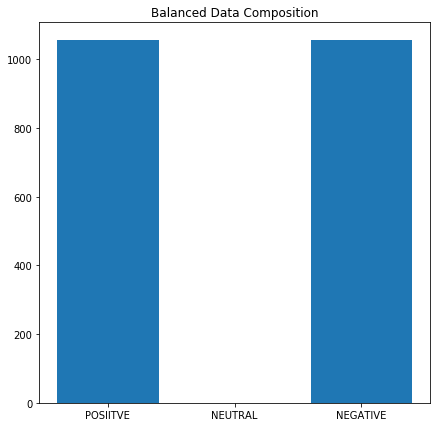

In [9]:
#plot fo data distribution

class_ = ["POSIITVE","NEUTRAL","NEGATIVE"]
data = [train_y.count("POSITIVE"),train_y.count("NEUTRAL"),train_y.count("NEGATIVE")]

plt.figure(figsize = (7,7))
plt.bar(class_,data)
plt.title("Balanced Data Composition")
plt.savefig("./plots/data_balance.png")

## Bag of words Vectorization

Links:
https://scikit-learn.org/stable/modules/feature_extraction.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Consider this two sentenses 

1) Excellent Services by the world remit team.Recomend.

2) Bad Services. Transaction delayed for three days.Don't recommend.

From above two sentenses can be writen as a bag of words as follows (no word repetition):

**Excellent Services by the world remit team recommend bad transaction delayed for three days don't**

We now tokenize this bag of words as shown below.

----
| 0 | Excellent | Sevices| by | the | world | remit | team | recommend | bad | services | transaction | delayed | for | three | days | don't |
| --- | --- | ---| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 1| 1 | 1 | 1 | 1 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 |
| 2 | 0 | 1| 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |

In [10]:
# Vectorizaation on sklearn - simple example
corpus = [
    'This is the first document.',
    'This document is the second document.',
     'And this is the third one.',
    'Is this the first document?',
 ]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(X) #this is just a matrix with position as tuple and token in that position
print(vectorizer.get_feature_names()) #all unique words in all 
print(X.toarray())#clearnly a matrix with each row as the tokenized values of each sentense

  (0, 8)	1
  (0, 3)	1
  (0, 6)	1
  (0, 2)	1
  (0, 1)	1
  (1, 8)	1
  (1, 3)	1
  (1, 6)	1
  (1, 1)	2
  (1, 5)	1
  (2, 8)	1
  (2, 3)	1
  (2, 6)	1
  (2, 0)	1
  (2, 7)	1
  (2, 4)	1
  (3, 8)	1
  (3, 3)	1
  (3, 6)	1
  (3, 2)	1
  (3, 1)	1
['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [11]:

vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

print(train_x[10])
print(train_x_vectors[10])
print(train_x_vectors[10].toarray())



They unnecessarily stop your transactions and and ask for ID, once provided they start asking for recipient ID. Once I uploaded this government ID, it refused it because it wasn’t in English? So why the hell would you give me the option to upload it? They don’t respond to you quick and I had to keep chasing them up. Also when I was chatting to the online web chat, I asked why I had to upload all of these ID and I was told it was the laws of the countries, so then I asked how come my uncle who sent the same amount wasn’t required to do this (Upload ID) a few days ago and then she apologised for lying to me. So it’s all just unnecessary headache. Avoid
  (0, 661)	0.08833690249445195
  (0, 2389)	0.12623834598348602
  (0, 5250)	0.12143222577621235
  (0, 3031)	0.12623834598348602
  (0, 521)	0.13301219196149594
  (0, 4509)	0.07591442032400252
  (0, 2050)	0.07434705044436425
  (0, 4196)	0.09935049716003043
  (0, 475)	0.07138444458218961
  (0, 4338)	0.067162708144117
  (0, 5487)	0.069049531288

### Fitting Sklearn Classifier

### 1.Suppport Vector Machine

670
why has my honest but critical review of World Remit posted yesterday been removed? Do you censor negative comments? So far, the dispute with them has cost me over 2 hours of effort. Calling them on the phone to complain takes a long time, and the four people I have spoken to by phone simply procrastinate. Complaints on the web are registered but appear never to be replied to. I had a good experience with them for 18 months, but the 19th transaction was very problematic and is not yet resolved.
Actual: NEGATIVE
Prediction ['NEGATIVE']


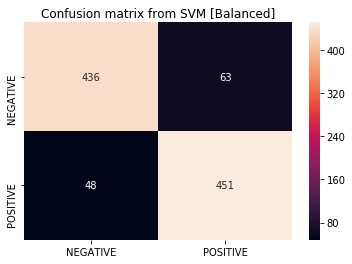

In [12]:


#train SVM classifier
clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, train_y)
#random prediction using SVM

i = np.random.randint(0,1000)
print(i)
print(test_x[i])
print("Actual:",test_y[i])
print("Prediction",clf_svm.predict(test_x_vectors[i]))

#confusion matrix  for SVM - you can have the confusion matrices for the other classifiers
labels = ["NEGATIVE","POSITIVE"]
pred_svm = clf_svm.predict(test_x_vectors)
cm =confusion_matrix(test_y,pred_svm)

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sb.heatmap(df_cm, annot=True, fmt='d') #truth is on "y" and predicted is on "x".
plt.title("Confusion matrix from SVM [Balanced]")
plt.savefig("./plots/confusion_balanced.png")

### 2) Decision Trees

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

i = np.random.randint(0,1000)
print(i)
print(test_x[i])
print("Actual:",test_y[i])
print("Prediction",clf_dec.predict(test_x_vectors[0]))



494
Beware of those Scammers. They take your money and then the show begins. Prepare yourself to call them every day, send same papers. Answer strange questions, everything necessary to hold your money and never pay your transaction.
Actual: NEGATIVE
Prediction ['POSITIVE']


### 3) Naive Bayes (Gaussian)

In [14]:


clf_gnb = DecisionTreeClassifier()
clf_gnb.fit(train_x_vectors, train_y)

clf_gnb.predict(test_x_vectors[0])


i = np.random.randint(0,1000)
print(i)
print(test_x[i])
print("Actual:",test_y[i])
print("Prediction",clf_gnb.predict(test_x_vectors[0]))



656
Fabulous service. Goodbye western union
Actual: POSITIVE
Prediction ['POSITIVE']


### 4) Logistic Regression

In [15]:


clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)

clf_log.predict(test_x_vectors[0])



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['POSITIVE'], dtype='<U8')

### 4) Ensemble Random Forest

In [16]:
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf.fit(train_x_vectors, train_y)

i = np.random.randint(0,1000)
print(i)
print(test_x[i])
print("Actual:",test_y[i])
print("Prediction",clf_rf.predict(test_x_vectors[0]))



714
If you use their services make sure you don't do a back-to-back payment because they will just cancel your account even after you send them all the information that they are asking for and you prove your identity
Actual: NEGATIVE
Prediction ['POSITIVE']


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Scoring all the models fitted

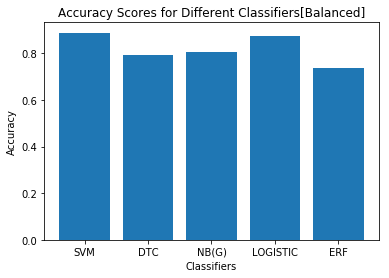

<Figure size 504x504 with 0 Axes>

0.8887775551102205
0.7935871743486974
0.8046092184368737
0.8767535070140281
0.7394789579158316


In [17]:
classifiers = ["SVM","DTC","NB(G)","LOGISTIC","ERF"]

svm_score = clf_svm.score(test_x_vectors, test_y)

dtc_score = clf_dec.score(test_x_vectors, test_y)

nbg_score = clf_gnb.score(test_x_vectors, test_y)

logistic_score = clf_log.score(test_x_vectors, test_y)

rf_score = clf_rf.score(test_x_vectors, test_y)

scores =[svm_score,dtc_score,nbg_score,logistic_score,rf_score ]

plt.bar(classifiers,scores)
plt.title("Accuracy Scores for Different Classifiers[Balanced]")
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.savefig("./plots/accuracy[Balanced].png")
plt.figure(figsize=(7,7))
plt.show()

print(svm_score)
print(dtc_score)
print(nbg_score)
print(logistic_score )
print(rf_score )


[0.89042448 0.88708037]
[0.79724409 0.78979592]
[0.80712166 0.80203046]
[0.87761194 0.87588295]
[0.76827094 0.70251716]


/usr/lib/python3/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


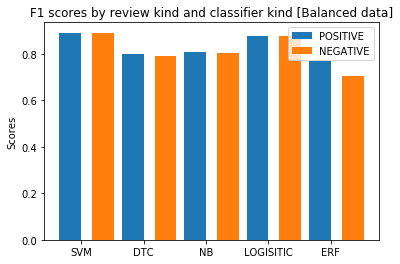

In [18]:
# F1 Scores

#calculating f1 score
f1_svm =(f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, 
                  labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))
f1_dtc = (f1_score(test_y, clf_dec.predict(test_x_vectors), average=None, 
                   labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))
f1_nb = (f1_score(test_y, clf_gnb.predict(test_x_vectors), average=None, 
                  labels=[Sentiment.POSITIVE,  Sentiment.NEGATIVE]))

f1_logistic = (f1_score(test_y, clf_log.predict(test_x_vectors), average=None, 
                        labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))

f1_rf = (f1_score(test_y, clf_rf.predict(test_x_vectors), average=None, 
                        labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE]))
# plotting f1 scores

classifiers = ["SVM","DTC","NB","LOGISITIC","ERF"]
f1_svm_,f1_dtc_,f1_nb_,f1_logistic_,f1_rf_= list(f1_svm),list(f1_dtc),list(f1_nb),list(f1_logistic),list(f1_rf)
data = []
for i,j,k,l,m in zip(f1_svm_,f1_dtc_,f1_nb_,f1_logistic_,f1_rf_):
    data.append([i,j,k,l,m])
    
x = np.arange(len(classifiers))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data[0], width, label='POSITIVE')
rects3 = ax.bar(x + width, data[1], width, label='NEGATIVE')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('F1 scores by review kind and classifier kind [Balanced data]')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
plt.savefig("./plots/f1_balanced.png")
fig.show()

#print f1 scores
print(f1_svm)
print(f1_dtc)
print(f1_nb)
print(f1_logistic)
print(f1_rf)

### Saving the trained models as .json file

In [19]:
import pickle

with open('./models/review_classifier.pkl', 'wb') as f:
    pickle.dump(clf_svm, f)

In [20]:
with open('./models/review_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [21]:
print(test_x[120])

loaded_clf.predict(test_x_vectors[120])

The moment you finish the transaction the money is sent and the receiver get it right way ! Fantastic


array(['POSITIVE'], dtype='<U8')

### Test your texts

In [22]:
test_set = ['very fun', "Really bad service!!", 'Fast']
new_test = vectorizer.transform(test_set)

clf_svm.predict(new_test)


array(['POSITIVE', 'NEGATIVE', 'POSITIVE'], dtype='<U8')